In [4]:
import os
from collections import defaultdict

import pandas as pd
import numpy as np
import sklearn
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from tensorflow import keras

In [5]:
!pip install lightgbm

In [6]:
from lightgbm import LGBMClassifier

In [7]:
seed = 130

def load_data():
  
    # Presence absence features
    train_pa_genes = pd.read_csv('../data/train_test_data/train_pa_genes.csv').set_index('genome_id')
    test_pa_genes = pd.read_csv('../data/train_test_data/test_pa_genes.csv').set_index('genome_id')
    
    # Load Kmer data
    train_kmers = np.load('../data/train_test_data/train_kmers.npy', allow_pickle=True)
    test_kmers = np.load('../data/train_test_data/test_kmers.npy', allow_pickle=True)

    # Load target data & IDs
    y_train = np.load('../data/train_test_data/y_train.npy', allow_pickle=True)
    y_train_ids = np.load('../data/train_test_data/train_ids.npy', allow_pickle=True).astype(str)
    y_test_ids = np.load('../data/train_test_data/test_ids.npy', allow_pickle=True).astype(str)

    # Load raw gene data for optional neural network section
    train_gene_alignment = pd.read_csv('../data/train_test_data/train_genes.csv')
    
    return train_pa_genes, test_pa_genes, train_kmers, test_kmers, y_train, y_train_ids, y_test_ids, train_gene_alignment

train_pa_genes, test_pa_genes, X_train_kmers, X_test_kmers, y_train, y_train_ids, y_test_ids, train_gene_alignment = load_data()

Dataset Preprocessing

In [8]:
X_train_pa = np.array(train_pa_genes)
X_test_pa = np.array(test_pa_genes)

Sample Weighting

In [12]:
sample_weights = sklearn.utils.class_weight.compute_sample_weight("balanced", y_train)

# Check the weights for a few samples
pd.DataFrame(list(zip(y_train[0:10], sample_weights[0:10])), columns=['y_train', 'weight'])

,y_train,weight
0,[S],0.625418
1,[S],0.625418
2,[S],0.625418
3,[S],0.625418
4,[S],0.625418
5,[S],0.625418
6,[R],2.493333
7,[S],0.625418
8,[R],2.493333
9,[R],2.493333


In [15]:
# Combine PA features and k-mer features
X_train = np.hstack((X_train_pa, X_train_kmers))
X_train = X_train.astype(np.float32)

In [16]:
X_test = np.hstack((X_test_pa, X_test_kmers))
X_test = X_test.astype(np.float32)

Baseline Model- Random Forest

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Function for cross-validation and hyperparameter tuning
def tune_model(model, param_grid, X, y, cv=5):
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X, y)
    return grid_search.best_estimator_, grid_search.best_score_

# Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}
rf_model = RandomForestClassifier(random_state=seed)
best_rf, rf_score = tune_model(rf_model, rf_param_grid, X_train, y_train)

print(f"Best Random Forest Score: {rf_score}")
print(f"Best Random Forest Parameters: {best_rf.get_params()}")


c:\Users\anayn\miniconda3\envs\ml_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Random Forest Score: 0.8943445190156598
Best Random Forest Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 130, 'verbose': 0, 'warm_start': False}


In [2]:
!pip install tqdm

Random Forest and Gradient Boosting

In [ ]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from tqdm import tqdm

seed = 42  # Random seed

# Subsample the data (reduce dataset size for testing)
from sklearn.model_selection import train_test_split
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, test_size=0.7, random_state=seed, stratify=y_train)

# Function for tuning
def tune_model_randomized(model, param_distributions, X, y, n_iter=10, cv=3):
    random_search = RandomizedSearchCV(
        model, param_distributions, n_iter=n_iter, cv=cv,
        scoring='accuracy', random_state=seed, n_jobs=1, verbose=1
    )
    random_search.fit(X, y)
    return random_search.best_estimator_, random_search.best_score_

# Random Forest
rf_param_distributions = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_model = RandomForestClassifier(random_state=seed)
best_rf, rf_score = tune_model_randomized(rf_model, rf_param_distributions, X_sample, y_sample)

print(f"Best Random Forest Score: {rf_score}")
print(f"Best Random Forest Parameters: {best_rf.get_params()}")

# Gradient Boosting
gb_param_distributions = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}
gb_model = GradientBoostingClassifier(random_state=seed)
best_gb, gb_score = tune_model_randomized(gb_model, gb_param_distributions, X_sample, y_sample)

print(f"Best Gradient Boosting Score: {gb_score}")
print(f"Best Gradient Boosting Parameters: {best_gb.get_params()}")

# LightGBM
lgb_param_distributions = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 63],
    'subsample': [0.8, 1.0]
}


# Perform cross-validation on the best models
cv_scores = {
    'Random Forest': cross_val_score(best_rf, X_sample, y_sample, cv=3, scoring='accuracy'),
    'Gradient Boosting': cross_val_score(best_gb, X_sample, y_sample, cv=3, scoring='accuracy'),
    
}

# Print cross-validation scores
for model, scores in cv_scores.items():
    print(f"\n{model} CV Scores: {scores}")
    print(f"{model} Mean CV Score: {np.mean(scores)}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\anayn\miniconda3\envs\ml_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\anayn\miniconda3\envs\ml_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\anayn\miniconda3\envs\ml_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\anayn\miniconda3\envs\ml_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

Best Random Forest Score: 0.9196396396396396
Best Random Forest Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\anayn\miniconda3\envs\ml_env\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\anayn\miniconda3\envs\ml_env\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\anayn\miniconda3\envs\ml_env\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\anayn\miniconda3\envs\ml_env\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d

Best Gradient Boosting Score: 0.9240840840840842
Best Gradient Boosting Parameters: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 0.8, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\anayn\miniconda3\envs\ml_env\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\anayn\miniconda3\envs\ml_env\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


KeyboardInterrupt: 

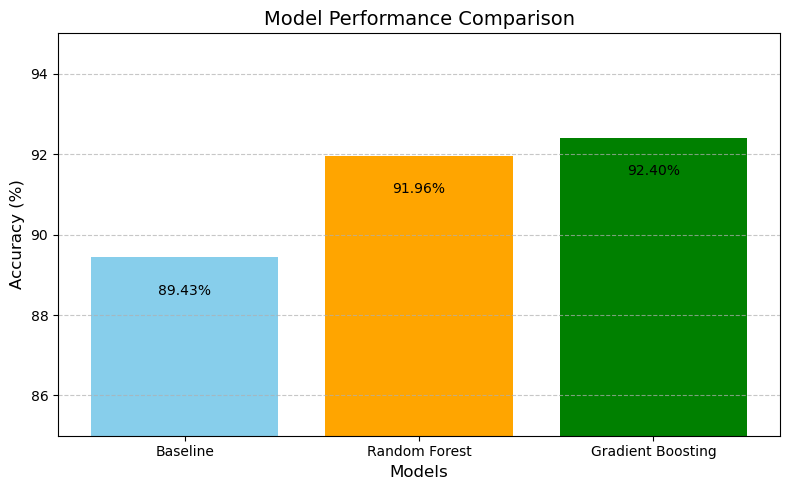

In [1]:
import matplotlib.pyplot as plt

# Model names and their corresponding accuracy scores
models = ['Baseline', 'Random Forest', 'Gradient Boosting']
accuracies = [89.43, 91.96, 92.40]

# Create a bar graph
plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['skyblue', 'orange', 'green'])

# Add values on top of each bar
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 1,
             f"{acc:.2f}%", ha='center', va='bottom', fontsize=10, color='black')

# Title and labels
plt.title('Model Performance Comparison', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.ylim(85, 95)  # Set y-axis limits for better visualization

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
